# Simple Pitching Clustering by PitchType Percentage only

## Preprocess data

In [29]:
import pandas as pd
import glob
import os

root_dir = "./statcast_pitcher_data/"

all_dfs = []

# pattern: pitch_arsenals-rh-2020.csv
files = glob.glob(os.path.join(root_dir, "pitch_arsenals-*-*.csv"))

for filepath in files:
    # get filename only
    filename = os.path.basename(filepath)  # e.g., pitch_arsenals-rh-2020.csv
    
    # split using '-'
    parts = filename.replace(".csv", "").split("-")
    # parts → ["pitch_arsenals", "rh", "2020"]
    
    handedness_raw = parts[1]   # "rh" or "lh"
    year_raw = parts[2]         # "2020"... "2025"
    
    handedness = "R" if handedness_raw.lower() == "rh" else "L"
    year = int(year_raw)

    # load CSV
    df = pd.read_csv(filepath)

    # add columns
    df["year"] = year
    df["handedness"] = handedness

    all_dfs.append(df)

# combine into a single DataFrame
pitch_df = pd.concat(all_dfs, ignore_index=True)

# pitch_df.head()


In [30]:
pitch_df.fillna(0, inplace=True)
# pitch_df.head()

In [31]:
rename_map = {
    "n_ff": "four_seam",
    "n_si": "sinker",
    "n_fc": "cutter",
    "n_sl": "slider",
    "n_ch": "changeup",
    "n_cu": "curveball",
    "n_fs": "splitter",
    "n_kn": "knuckleball",
    "n_st": "sweeper",
    "n_sv": "screwball"
}

pitch_df = pitch_df.rename(columns=rename_map)
pitch_df.head()

,"last_name, first_name",pitcher,four_seam,sinker,cutter,slider,changeup,curveball,splitter,knuckleball,sweeper,screwball,year,handedness
0,"Ryu, Hyun Jin",547943,24.6,10.0,24.4,0.0,27.8,13.2,0.0,0.0,0.0,0.0,2020,L
1,"Freeland, Kyle",607536,21.0,12.2,23.6,0.0,24.4,18.9,0.0,0.0,0.0,0.0,2020,L
2,"Boyd, Matthew",571510,50.3,2.4,0.0,22.7,17.2,7.5,0.0,0.0,0.0,0.0,2020,L
3,"Heaney, Andrew",571760,57.8,0.0,0.0,0.4,17.4,24.4,0.0,0.0,0.0,0.0,2020,L
4,"Corbin, Patrick",571578,17.2,34.8,0.0,40.3,5.6,2.1,0.0,0.0,0.0,0.0,2020,L


## Clustering by pitch usage only

### K Means Clustering

In [32]:
import numpy as np

pitch_cols = [
    "four_seam", "sinker", "cutter", "slider", "changeup",
    "curveball", "splitter", "knuckleball", "sweeper", "screwball"
]

# total pitches per pitcher
pitch_df["total_pitches"] = pitch_df[pitch_cols].sum(axis=1)

# drop pitchers with no pitches (just in case)
pitch_df = pitch_df[pitch_df["total_pitches"] > 0].copy()

# convert to percentages
for col in pitch_cols:
    pitch_df[col + "_pct"] = pitch_df[col] / pitch_df["total_pitches"]

feature_cols = [c + "_pct" for c in pitch_cols]

X = pitch_df[feature_cols].values


In [33]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [34]:
# X_used = X_scaled  # or X if you skip StandardScaler
X_used = X  # if you skip StandardScaler

KMeans k=2: silhouette=0.2969
KMeans k=3: silhouette=0.2291
KMeans k=4: silhouette=0.2112
KMeans k=5: silhouette=0.2127
KMeans k=6: silhouette=0.2028
KMeans k=7: silhouette=0.1953
KMeans k=8: silhouette=0.1955
KMeans k=9: silhouette=0.1955
KMeans k=10: silhouette=0.2039


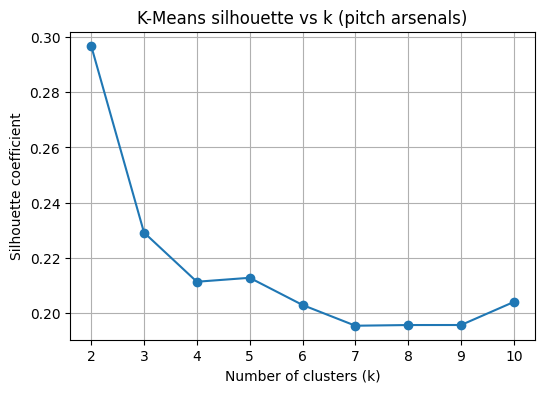

Best k for KMeans: 2


In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_values = range(2, 11)  # try 2..10 clusters
sil_scores_kmeans = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        n_init=10,
        random_state=42
    )
    labels = kmeans.fit_predict(X_used)
    score = silhouette_score(X_used, labels)
    sil_scores_kmeans.append(score)
    print(f"KMeans k={k}: silhouette={score:.4f}")

# plot silhouette vs k
plt.figure(figsize=(6, 4))
plt.plot(list(k_values), sil_scores_kmeans, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette coefficient")
plt.title("K-Means silhouette vs k (pitch arsenals)")
plt.grid(True)
plt.show()

# fit final KMeans at best k
best_k_kmeans = k_values[int(np.argmax(sil_scores_kmeans))]
print("Best k for KMeans:", best_k_kmeans)

kmeans_final = KMeans(
    n_clusters=best_k_kmeans,
    n_init=10,
    random_state=42
)
pitch_df["kmeans_cluster"] = kmeans_final.fit_predict(X_used)


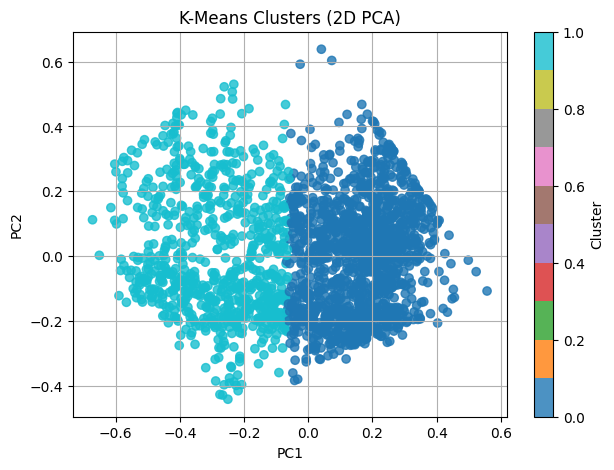

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming X_used is your standardized/normalized matrix
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_used)

plt.figure(figsize=(7,5))
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=pitch_df["kmeans_cluster"],
    cmap="tab10",
    alpha=0.8
)
plt.title("K-Means Clusters (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()


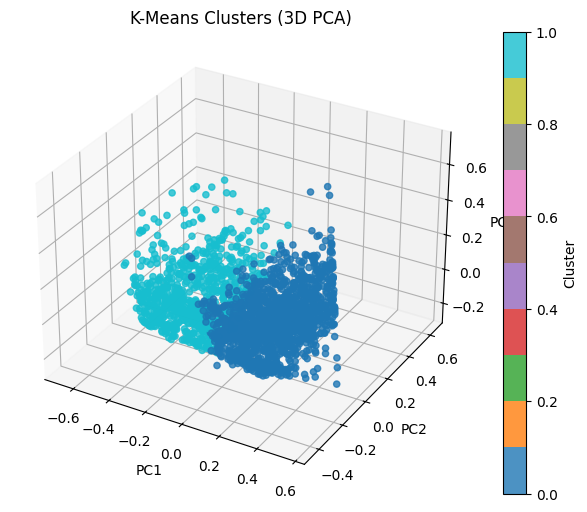

In [37]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_used)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_3d[:,0], X_3d[:,1], X_3d[:,2],
    c=pitch_df["kmeans_cluster"],
    cmap="tab10",
    alpha=0.8
)

ax.set_title("K-Means Clusters (3D PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

fig.colorbar(scatter, label="Cluster")
plt.show()


### HAC Clustering

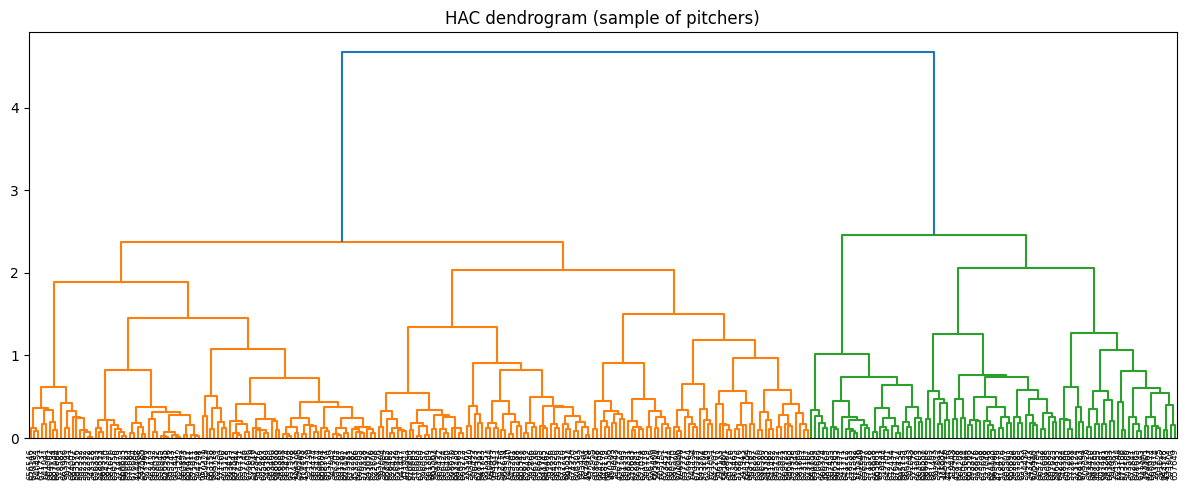

In [38]:
from scipy.cluster.hierarchy import linkage, dendrogram

# sample some pitchers for dendrogram (to avoid 5k tiny labels)
max_sample = 300
if len(pitch_df) > max_sample:
    sample_idx = np.random.choice(pitch_df.index, size=max_sample, replace=False)
else:
    sample_idx = pitch_df.index

X_sample = X_used[pitch_df.index.get_indexer(sample_idx)]

Z = linkage(X_sample, method="ward")  

plt.figure(figsize=(12, 5))
dendrogram(
    Z,
    labels=pitch_df.loc[sample_idx, "pitcher"].astype(str).values,
    leaf_rotation=90,
    leaf_font_size=6,
)
plt.title("HAC dendrogram (sample of pitchers)")
plt.tight_layout()
plt.show()


HAC k=2: silhouette=0.3033
HAC k=3: silhouette=0.1852
HAC k=4: silhouette=0.1958
HAC k=5: silhouette=0.1686
HAC k=6: silhouette=0.1753
HAC k=7: silhouette=0.1348
HAC k=8: silhouette=0.1317
HAC k=9: silhouette=0.1401
HAC k=10: silhouette=0.1452


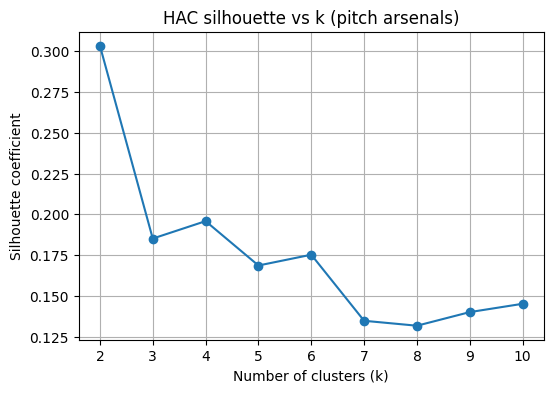

Best k for HAC: 2


In [39]:
from sklearn.cluster import AgglomerativeClustering

sil_scores_hac = []

for k in k_values:
    hac = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward"
    )
    labels = hac.fit_predict(X_used)
    score = silhouette_score(X_used, labels)
    sil_scores_hac.append(score)
    print(f"HAC k={k}: silhouette={score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(list(k_values), sil_scores_hac, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette coefficient")
plt.title("HAC silhouette vs k (pitch arsenals)")
plt.grid(True)
plt.show()

best_k_hac = k_values[int(np.argmax(sil_scores_hac))]
print("Best k for HAC:", best_k_hac)

hac_final = AgglomerativeClustering(
    n_clusters=best_k_hac,
    linkage="ward"
)
pitch_df["hac_cluster"] = hac_final.fit_predict(X_used)


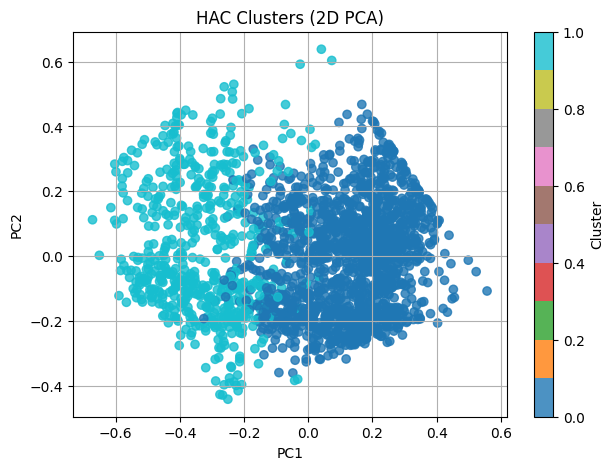

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_used)

plt.figure(figsize=(7,5))
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=pitch_df["hac_cluster"],
    cmap="tab10",
    alpha=0.8
)
plt.title("HAC Clusters (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()


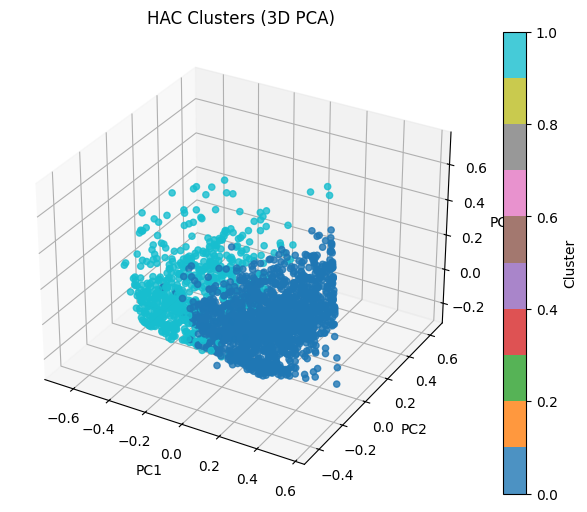

In [41]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_used)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_3d[:,0], X_3d[:,1], X_3d[:,2],
    c=pitch_df["hac_cluster"],
    cmap="tab10",
    alpha=0.8
)

ax.set_title("HAC Clusters (3D PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

fig.colorbar(scatter, label="Cluster")
plt.show()


### Determining names of clusters

In [42]:
pitch_df[["last_name, first_name", "pitcher", "year", "kmeans_cluster"]].head()

,"last_name, first_name",pitcher,year,kmeans_cluster
0,"Ryu, Hyun Jin",547943,2020,1
1,"Freeland, Kyle",607536,2020,1
2,"Boyd, Matthew",571510,2020,0
3,"Heaney, Andrew",571760,2020,0
4,"Corbin, Patrick",571578,2020,1


In [43]:
pitch_df.sort_values("kmeans_cluster").head(20)


,"last_name, first_name",pitcher,four_seam,sinker,cutter,slider,changeup,curveball,splitter,knuckleball,...,cutter_pct,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct,kmeans_cluster,hac_cluster
21,"Yarbrough, Ryan",642232,23.3,0.0,36.0,0.0,30.0,0.0,0.0,0.0,...,0.360000,0.000000,0.300000,0.000000,0.000000,0.0,0.107,0.0,0,0
22,"Peterson, David",656849,37.4,15.8,0.0,25.9,18.7,2.2,0.0,0.0,...,0.000000,0.259000,0.187000,0.022000,0.000000,0.0,0.000,0.0,0,0
25,"Kikuchi, Yusei",579328,37.7,0.0,40.0,16.0,6.3,0.0,0.0,0.0,...,0.400000,0.160000,0.063000,0.000000,0.000000,0.0,0.000,0.0,0,0
26,"Happ, J.A.",457918,44.3,22.0,0.0,18.7,13.9,1.1,0.0,0.0,...,0.000000,0.187000,0.139000,0.011000,0.000000,0.0,0.000,0.0,0,0
13,"Duffy, Danny",518633,38.5,15.0,0.0,17.2,15.3,14.1,0.0,0.0,...,0.000000,0.171828,0.152847,0.140859,0.000000,0.0,0.000,0.0,0,0
14,"Luzardo, Jesús",666200,31.0,22.2,0.0,22.8,24.0,0.0,0.0,0.0,...,0.000000,0.228000,0.240000,0.000000,0.000000,0.0,0.000,0.0,0,0
15,"Bubic, Kris",663460,54.2,0.0,0.0,0.0,29.9,15.9,0.0,0.0,...,0.000000,0.000000,0.299000,0.159000,0.000000,0.0,0.000,0.0,0,0
2113,"Festa, David",701581,31.7,12.5,0.0,26.8,29.0,0.0,0.0,0.0,...,0.000000,0.268000,0.290000,0.000000,0.000000,0.0,0.000,0.0,0,0
2114,"Jobe, Jackson",695549,31.1,13.1,0.0,30.6,16.9,8.1,0.0,0.0,...,0.000000,0.306000,0.169000,0.081000,0.000000,0.0,0.002,0.0,0,0
2118,"Ross, Joe",605452,37.2,26.7,0.0,22.2,8.6,5.3,0.0,0.0,...,0.000000,0.222000,0.086000,0.053000,0.000000,0.0,0.000,0.0,0,0


In [44]:
pitch_df[pitch_df.kmeans_cluster == 0]


,"last_name, first_name",pitcher,four_seam,sinker,cutter,slider,changeup,curveball,splitter,knuckleball,...,cutter_pct,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct,kmeans_cluster,hac_cluster
2,"Boyd, Matthew",571510,50.3,2.4,0.0,22.7,17.2,7.5,0.0,0.0,...,0.000000,0.226773,0.171828,0.074925,0.000000,0.0,0.000000,0.0,0,0
3,"Heaney, Andrew",571760,57.8,0.0,0.0,0.4,17.4,24.4,0.0,0.0,...,0.000000,0.004000,0.174000,0.244000,0.000000,0.0,0.000000,0.0,0,0
5,"Ray, Robbie",592662,47.4,3.6,0.0,29.4,2.7,16.9,0.0,0.0,...,0.000000,0.294000,0.027000,0.169000,0.000000,0.0,0.000000,0.0,0,0
6,"Gonzales, Marco",594835,45.4,0.0,24.2,0.0,14.3,16.1,0.0,0.0,...,0.242000,0.000000,0.143000,0.161000,0.000000,0.0,0.000000,0.0,0,0
10,"Minor, Mike",501985,50.7,0.1,0.0,20.7,22.1,6.4,0.0,0.0,...,0.000000,0.207000,0.221000,0.064000,0.000000,0.0,0.000000,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,"Fisher, Braydon",680755,22.1,0.0,3.0,38.3,0.0,36.6,0.0,0.0,...,0.030000,0.383000,0.000000,0.366000,0.000000,0.0,0.000000,0.0,0,0
2128,"Myers, Tobias",668964,45.2,0.0,19.5,16.8,1.5,1.5,15.6,0.0,...,0.194805,0.167832,0.014985,0.014985,0.155844,0.0,0.000000,0.0,0,0
2130,"Morales, Luis",806960,52.4,0.0,0.0,8.0,13.0,0.0,0.0,0.0,...,0.000000,0.080000,0.130000,0.000000,0.000000,0.0,0.266000,0.0,0,0
2131,"Beck, Tristan",663941,33.0,0.0,0.0,21.3,0.0,17.3,0.0,0.0,...,0.000000,0.213000,0.000000,0.173000,0.000000,0.0,0.284000,0.0,0,0


In [45]:
pitch_df.groupby("hac_cluster")[feature_cols].mean()


,four_seam_pct,sinker_pct,cutter_pct,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct
hac_cluster,,,,,,,,,,
0,0.429182,0.070567,0.056669,0.172623,0.106758,0.090083,0.027846,0.000415,0.041737,0.004121
1,0.094211,0.365047,0.124748,0.145839,0.102972,0.091878,0.013128,0.000008,0.060176,0.001993


In [46]:
pitch_df.groupby("kmeans_cluster")[feature_cols].mean()


,four_seam_pct,sinker_pct,cutter_pct,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct
kmeans_cluster,,,,,,,,,,
0,0.450920,0.050064,0.051018,0.182810,0.105359,0.093134,0.027667,0.000128,0.036553,0.002346
1,0.127119,0.338597,0.120257,0.133423,0.106272,0.086059,0.016593,0.000606,0.065465,0.005609


In [ ]:
cluster_name_map = {
    0: "Four-Seam & Slider Dominant (North–South Power Arms)",
    1: "Sinker & Cutter Dominant (East–West Movement Arms)"
}

pitch_df["hac_archetype"] = pitch_df["hac_cluster"].map(cluster_name_map)

In [49]:
pitch_df[[
    "last_name, first_name",
    "hac_archetype"
]].head(20)


,"last_name, first_name",hac_archetype
0,"Ryu, Hyun Jin",Four-Seam & Slider Dominant (North–South Power...
1,"Freeland, Kyle",Four-Seam & Slider Dominant (North–South Power...
2,"Boyd, Matthew",Four-Seam & Slider Dominant (North–South Power...
3,"Heaney, Andrew",Four-Seam & Slider Dominant (North–South Power...
4,"Corbin, Patrick",Sinker & Cutter Dominant (East–West Movement A...
5,"Ray, Robbie",Four-Seam & Slider Dominant (North–South Power...
6,"Gonzales, Marco",Four-Seam & Slider Dominant (North–South Power...
7,"Valdez, Framber",Sinker & Cutter Dominant (East–West Movement A...
8,"Pérez, Martín",Sinker & Cutter Dominant (East–West Movement A...
9,"Lester, Jon",Four-Seam & Slider Dominant (North–South Power...


In [50]:
pitch_df[pitch_df["last_name, first_name"].str.contains("Yamamoto", case=False)]


,"last_name, first_name",pitcher,four_seam,sinker,cutter,slider,changeup,curveball,splitter,knuckleball,...,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct,kmeans_cluster,hac_cluster,hac_archetype
1726,"Yamamoto, Yoshinobu",808967,40.5,2.8,6.1,3.2,0.0,23.1,24.2,0.0,...,0.032000,0.0,0.231000,0.242000,0.0,0.001,0.0,0,0,Four-Seam & Slider Dominant (North–South Power...
1909,"Yamamoto, Yoshinobu",808967,35.6,7.5,11.0,2.8,0.0,17.6,25.4,0.0,...,0.028028,0.0,0.176176,0.254254,0.0,0.000,0.0,0,0,Four-Seam & Slider Dominant (North–South Power...


## Clustering by pitchtype weighted by pitch value (runs per 100 pitches)

In [95]:
pitch_code_to_stat = {
    "FF": "four_seam_rv100",
    "SI": "sinker_rv100",
    "CH": "changeup_rv100",
    "SL": "slider_rv100",
    "CU": "curveball_rv100",
    "FS": "splitter_rv100",
    "FC": "cutter_rv100",
    "SV": "screwball_rv100",
    "ST": "sweeper_rv100"
}


In [96]:
pitch_code_to_pct = {
    "FF": "four_seam_pct",
    "SI": "sinker_pct",
    "CH": "changeup_pct",
    "SL": "slider_pct",
    "CU": "curveball_pct",
    "FS": "splitter_pct",
    "FC": "cutter_pct",
    "SV": "screwball_pct",
    "ST": "sweeper_pct"
}


In [97]:
import pandas as pd
import glob
import os

root_dir = "./statcast_pitcher_data/"

pitch_code_to_pct = {
    "FF": "four_seam_pct",
    "SI": "sinker_pct",
    "CH": "changeup_pct",
    "SL": "slider_pct",
    "CU": "curveball_pct",
    "FS": "splitter_pct",
    "FC": "cutter_pct",
    "SV": "screwball_pct",
    "ST": "sweeper_pct"
}

pitch_code_to_stat = {
    code: pct.replace("_pct", "_rv100")
    for code, pct in pitch_code_to_pct.items()
}

# --- Load stats files
stats_files = glob.glob(os.path.join(root_dir, "pitch-arsenal-stats-*.csv"))

stats_list = []
for filepath in stats_files:
    filename = os.path.basename(filepath)
    year = int(filename.replace(".csv", "").split("-")[-1])

    df = pd.read_csv(filepath)
    df["year"] = year
    stats_list.append(df)

stats_df = pd.concat(stats_list, ignore_index=True)

# --- Pivot stats into one row per pitcher/year
stats_pivot = stats_df.pivot_table(
    index=["player_id", "year"],
    columns="pitch_type",
    values="run_value_per_100"
).reset_index()

# Rename stat columns
stats_pivot = stats_pivot.rename(columns=pitch_code_to_stat)

# Fill missing stats
stats_pivot = stats_pivot.fillna(0)

# --- Merge mix + stats
merged = pitch_df.merge(
    stats_pivot,
    left_on=["pitcher", "year"],
    right_on=["player_id", "year"],
    how="left"
)

merged = merged.fillna(0)

# --- Create weighted values
weighted_feature_cols = []

for code, pct_col in pitch_code_to_pct.items():
    stat_col = pitch_code_to_stat[code]
    value_col = pct_col.replace("_pct", "_value")
    
    merged[value_col] = merged[pct_col] * merged[stat_col] *100
    weighted_feature_cols.append(value_col)

# --- Final weighted_df
weighted_df = merged[
    ["pitcher", "year", "handedness", "last_name, first_name"] +
    weighted_feature_cols
].copy()

weighted_df = weighted_df.fillna(0)


In [98]:
weighted_df.head()


,pitcher,year,handedness,"last_name, first_name",four_seam_value,sinker_value,changeup_value,slider_value,curveball_value,splitter_value,cutter_value,screwball_value,sweeper_value
0,547943,2020,L,"Ryu, Hyun Jin",-49.200000,-7.000000,69.500000,0.000000,15.840000,0.0,48.800000,0.0,0.0
1,607536,2020,L,"Freeland, Kyle",-12.587413,-12.187812,17.062937,0.000000,15.104895,0.0,-14.145854,0.0,0.0
2,571510,2020,L,"Boyd, Matthew",-70.349650,0.000000,15.464535,-65.764236,0.000000,0.0,0.000000,0.0,0.0
3,571760,2020,L,"Heaney, Andrew",23.120000,0.000000,19.140000,0.000000,4.880000,0.0,0.000000,0.0,0.0
4,571578,2020,L,"Corbin, Patrick",-53.320000,-48.720000,0.000000,36.270000,0.000000,0.0,0.000000,0.0,0.0


### K-Means

In [99]:
import numpy as np

weighted_cols = [c for c in weighted_df.columns if c.endswith("_value")]

X_weighted = weighted_df[weighted_cols].values

# Optional: fill any tiny numerical NaNs (shouldn't be any)
X_weighted = np.nan_to_num(X_weighted)


KMeans k=2: silhouette=0.1947
KMeans k=3: silhouette=0.1759
KMeans k=4: silhouette=0.1925
KMeans k=5: silhouette=0.1990
KMeans k=6: silhouette=0.2005
KMeans k=7: silhouette=0.1718
KMeans k=8: silhouette=0.1759
KMeans k=9: silhouette=0.1891
KMeans k=10: silhouette=0.1693


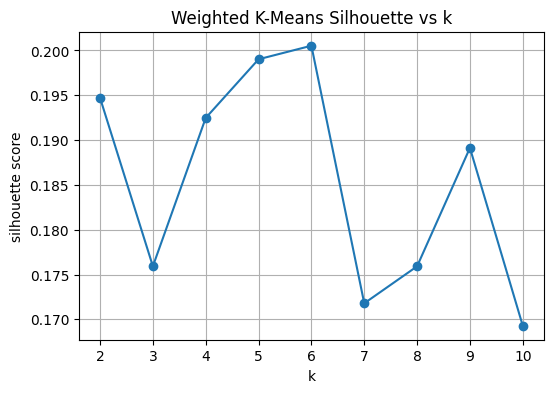

Best weighted k (K-Means): 6


In [100]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_values = range(2, 11)
sil_scores_kmeans = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_weighted)
    score = silhouette_score(X_weighted, labels)
    sil_scores_kmeans.append(score)
    print(f"KMeans k={k}: silhouette={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores_kmeans, marker="o")
plt.title("Weighted K-Means Silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.grid(True)
plt.show()

best_k_kmeans = k_values[int(np.argmax(sil_scores_kmeans))]
print("Best weighted k (K-Means):", best_k_kmeans)

# Save labels
kmeans_final = KMeans(n_clusters=best_k_kmeans, n_init=10, random_state=42)
weighted_df["kmeans_weighted_cluster"] = kmeans_final.fit_predict(X_weighted)


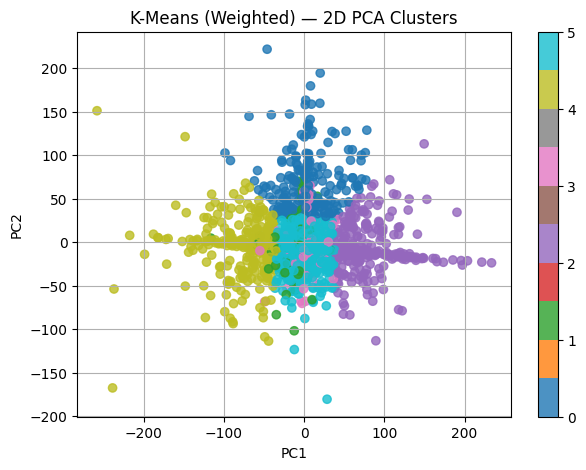

In [102]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
X2 = pca2.fit_transform(X_weighted)

plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=weighted_df["kmeans_weighted_cluster"], cmap="tab10", alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means (Weighted) — 2D PCA Clusters")
plt.grid(True)
plt.colorbar()
plt.show()


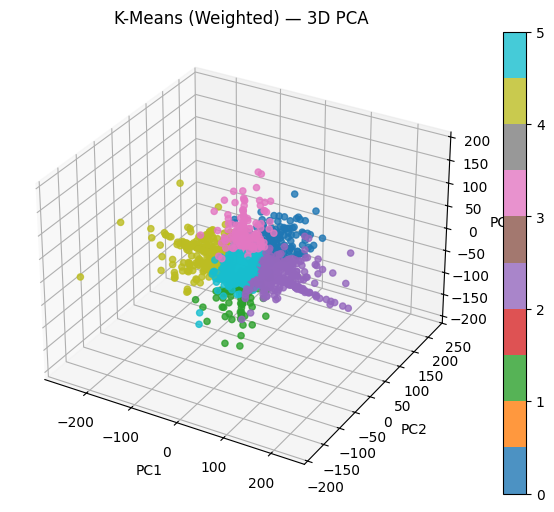

In [103]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
X3 = pca3.fit_transform(X_weighted)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X3[:,0], X3[:,1], X3[:,2],
    c=weighted_df["kmeans_weighted_cluster"],
    cmap="tab10",
    alpha=0.8
)

ax.set_title("K-Means (Weighted) — 3D PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.colorbar(scatter)
plt.show()


### HAC

HAC k=2: silhouette=0.1830
HAC k=3: silhouette=0.1347
HAC k=4: silhouette=0.1459
HAC k=5: silhouette=0.1407
HAC k=6: silhouette=0.1411
HAC k=7: silhouette=0.1443
HAC k=8: silhouette=0.1360
HAC k=9: silhouette=0.1291
HAC k=10: silhouette=0.1248


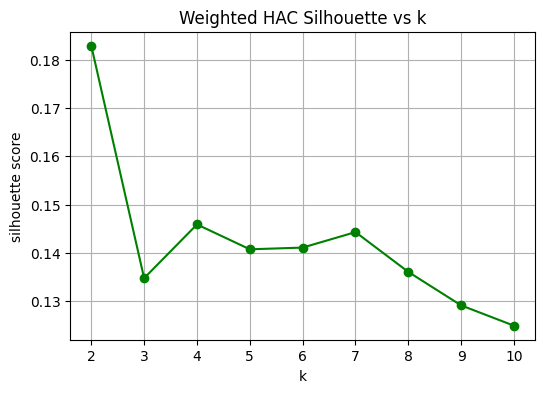

Best weighted k (HAC): 2


In [101]:
from sklearn.cluster import AgglomerativeClustering

sil_scores_hac = []

for k in k_values:
    hac = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = hac.fit_predict(X_weighted)
    score = silhouette_score(X_weighted, labels)
    sil_scores_hac.append(score)
    print(f"HAC k={k}: silhouette={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores_hac, marker="o", color="green")
plt.title("Weighted HAC Silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.grid(True)
plt.show()

best_k_hac = k_values[int(np.argmax(sil_scores_hac))]
print("Best weighted k (HAC):", best_k_hac)

weighted_df["hac_weighted_cluster"] = AgglomerativeClustering(
    n_clusters=best_k_hac,
    linkage="ward"
).fit_predict(X_weighted)


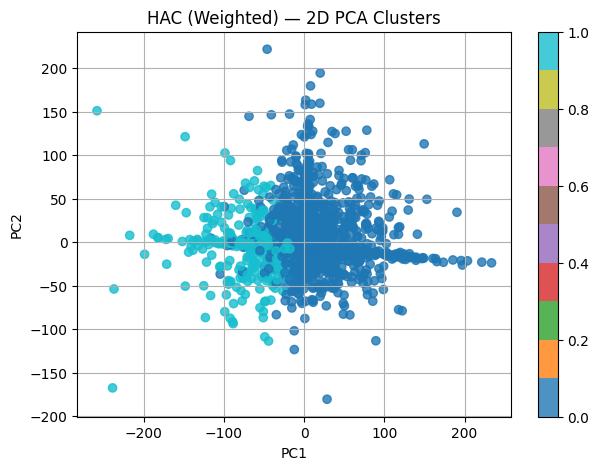

In [104]:
plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=weighted_df["hac_weighted_cluster"], cmap="tab10", alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("HAC (Weighted) — 2D PCA Clusters")
plt.grid(True)
plt.colorbar()
plt.show()


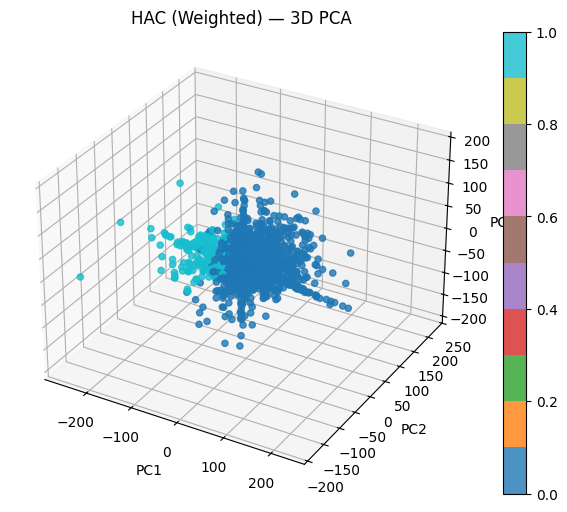

In [105]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X3[:,0], X3[:,1], X3[:,2],
    c=weighted_df["hac_weighted_cluster"],
    cmap="tab10",
    alpha=0.8
)

ax.set_title("HAC (Weighted) — 3D PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.colorbar(scatter)
plt.show()


### Finding cluster names

In [106]:
weighted_df.groupby("kmeans_weighted_cluster")[weighted_cols].mean()


,four_seam_value,sinker_value,changeup_value,slider_value,curveball_value,splitter_value,cutter_value,screwball_value,sweeper_value
kmeans_weighted_cluster,,,,,,,,,
0,1.227419,1.375392,0.665051,75.588584,3.621587,1.240175,2.589086,0.000000,0.463011
1,-5.556548,-60.534306,-5.038044,1.333586,-2.502892,-0.431090,-2.479863,0.000000,2.945995
2,78.214681,3.839752,2.940642,4.915608,-0.069195,1.726655,1.900228,0.071337,3.240713
3,-0.411061,73.079189,0.635967,4.838074,-0.642014,1.743336,1.971475,0.126402,2.630937
4,-69.439897,-0.316423,1.068044,-3.022861,-2.551798,1.523083,-1.002010,0.160551,-0.022899
5,3.515035,2.104819,2.596846,-1.812397,1.552507,1.130373,2.612401,0.333458,2.548719


In [109]:
weighted_cluster_names = {
    0: "Slider-Liability Pitchers (Hittable Breaking Balls)",
    1: "Elite Sinker–CH Groundball Specialists",
    2: "4-Seam Liability Pitchers (Weak Fastball Profiles)",
    3: "Ineffective Sinker-Heavy Arms (High-Damage Contact)",
    4: "Power Four-Seam Aces (FF-Forward Strikeout Arms)",
    5: "Unstable Secondary Mix Pitchers (Inconsistent Offspeed Suite)"
}

weighted_df["weighted_archetype"] = (
    weighted_df["kmeans_weighted_cluster"].map(weighted_cluster_names)
)


## Final pitcher archetypes

We will be moving forward with k-means on weighted pitch value clustering

In [110]:
weighted_df[[
    "pitcher",
    "last_name, first_name",
    "year",
    "handedness",
    "kmeans_weighted_cluster",
    "weighted_archetype",
    "four_seam_value",
    "sinker_value",
    "slider_value",
    "changeup_value",
    "curveball_value",
    "cutter_value",
    "splitter_value",
    "sweeper_value",
    "screwball_value"
]]


,pitcher,"last_name, first_name",year,handedness,kmeans_weighted_cluster,weighted_archetype,four_seam_value,sinker_value,slider_value,changeup_value,curveball_value,cutter_value,splitter_value,sweeper_value,screwball_value
0,547943,"Ryu, Hyun Jin",2020,L,4,Power Four-Seam Aces (FF-Forward Strikeout Arms),-49.200000,-7.000000,0.000000,69.500000,15.840000,48.800000,0.00000,0.000000,0.0
1,607536,"Freeland, Kyle",2020,L,5,Unstable Secondary Mix Pitchers (Inconsistent ...,-12.587413,-12.187812,0.000000,17.062937,15.104895,-14.145854,0.00000,0.000000,0.0
2,571510,"Boyd, Matthew",2020,L,4,Power Four-Seam Aces (FF-Forward Strikeout Arms),-70.349650,0.000000,-65.764236,15.464535,0.000000,0.000000,0.00000,0.000000,0.0
3,571760,"Heaney, Andrew",2020,L,5,Unstable Secondary Mix Pitchers (Inconsistent ...,23.120000,0.000000,0.000000,19.140000,4.880000,0.000000,0.00000,0.000000,0.0
4,571578,"Corbin, Patrick",2020,L,1,Elite Sinker–CH Groundball Specialists,-53.320000,-48.720000,36.270000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,668964,"Myers, Tobias",2025,R,5,Unstable Secondary Mix Pitchers (Inconsistent ...,-27.092907,0.000000,31.888112,0.000000,0.000000,-46.753247,49.87013,0.000000,0.0
2129,666374,"Brash, Matt",2025,R,0,Slider-Liability Pitchers (Hittable Breaking B...,0.000000,13.140000,60.600000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
2130,806960,"Morales, Luis",2025,R,5,Unstable Secondary Mix Pitchers (Inconsistent ...,-10.480000,0.000000,0.000000,32.500000,0.000000,0.000000,0.00000,7.980000,0.0
2131,663941,"Beck, Tristan",2025,R,5,Unstable Secondary Mix Pitchers (Inconsistent ...,13.200000,0.000000,29.820000,0.000000,-44.980000,0.000000,0.00000,56.800000,0.0
